**Greg Burns - 6/21/25 - EasyVisa Project**

# 1) Problem Statement

## 1a) Business Context

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## 1b) Objective

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data  scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

## 1c) Data Description

The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

# 2) Project Setup

## 2a) Install Libraries

In [2]:
# 2a) Install Libraries
!pip install --upgrade --quiet xgboost lightgbm catboost optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.3 MB/s eta 0:00:00


## 2b) Import Libraries

In [3]:
# 2b) Import Libraries

import os
import sys
import time
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

import sklearn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier

import optuna

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['SHAP_USE_GPU'] = '0'
import shap
shap.initjs()

np.random.seed(42)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Log library versions
print("Python:", sys.version)
print("pandas:", pd.__version__, "numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgb.__version__,
      "lightgbm:", lgb.__version__,
      "catboost:", catboost.__version__)
print("optuna:", optuna.__version__, "shap:", shap.__version__)
print("All libraries imported and versions logged successfully.")

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
pandas: 2.2.2 numpy: 2.0.2
scikit-learn: 1.6.1
xgboost: 2.1.4 lightgbm: 4.5.0 catboost: 1.2.8
optuna: 4.4.0 shap: 0.48.0
All libraries imported and versions logged successfully.


## 2c) Mount Drive

In [4]:
# 2c) Mount Drive

from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Define project and data directories
project_root = '/content/drive/MyDrive/EasyVisa'
data_path = os.path.join(project_root, 'data')
os.makedirs(data_path, exist_ok=True)

# Confirm
print("Drive mounted successfully.")
print(f"Project root: {project_root}")
print(f"Data directory: {data_path}")

Mounted at /content/drive
Drive mounted successfully.
Project root: /content/drive/MyDrive/EasyVisa
Data directory: /content/drive/MyDrive/EasyVisa/data


# 3) Data Load & Review  

## 3a) Load Data  

In [48]:
# 3a) Load Data

# Define the path to the CSV
data_file = os.path.join(data_path, 'EasyVisa.csv')

# Load into a DataFrame
easyvisa = pd.read_csv(data_file)

# Confirm load
print(f"Loaded {easyvisa.shape[0]} rows and {easyvisa.shape[1]} columns from {data_file}")

# Make copy of data
df = easyvisa.copy()

# Print head of data
df.head()

Loaded 25480 rows and 12 columns from /content/drive/MyDrive/EasyVisa/data/EasyVisa.csv


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


## 3b) Review Data

In [49]:
# 3b) Review Data

# Shape
print("--- DataFrame Shape ---")
print(df.shape)

# Schema & Non-Null Counts
print("\n--- Data Schema and Non-Null Counts ---")
df.info()

# Missing Values & Duplicates
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())
print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())

# Descriptive Statistics
print("\n" + "-"*40 + "\n")
print("--- Descriptive Statistics (Numeric) ---")
display(df.describe())
print("\n" + "-"*40 + "\n")
print("--- Descriptive Statistics (Categorical) ---")
display(df.describe(include=['object']))

# Key Category Distributions
for col in ['case_status', 'continent', 'education_of_employee']:
    print("\n" + "-"*40)
    print(f"Value counts for {col}:")
    print(df[col].value_counts(dropna=False))

--- DataFrame Shape ---
(25480, 12)

--- Data Schema and Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

--- Missing Values per 

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000



----------------------------------------

--- Descriptive Statistics (Categorical) ---


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,case_status
count,25480,25480,25480,25480,25480,25480,25480,25480,25480
unique,25480,6,4,2,2,5,4,2,2
top,EZYV25480,Asia,Bachelor's,Y,N,Northeast,Year,Y,Certified
freq,1,16861,10234,14802,22525,7195,22962,22773,17018



----------------------------------------
Value counts for case_status:
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

----------------------------------------
Value counts for continent:
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64

----------------------------------------
Value counts for education_of_employee:
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64


**Observations**
* There are no missing values or duplicate rows.
* There is a 2:1 ratio of "Certified" to "Denied" applications.
* The no_of_employees column contains negative values.

## 3c) Initial EDA

--- 3c) Initial EDA ---



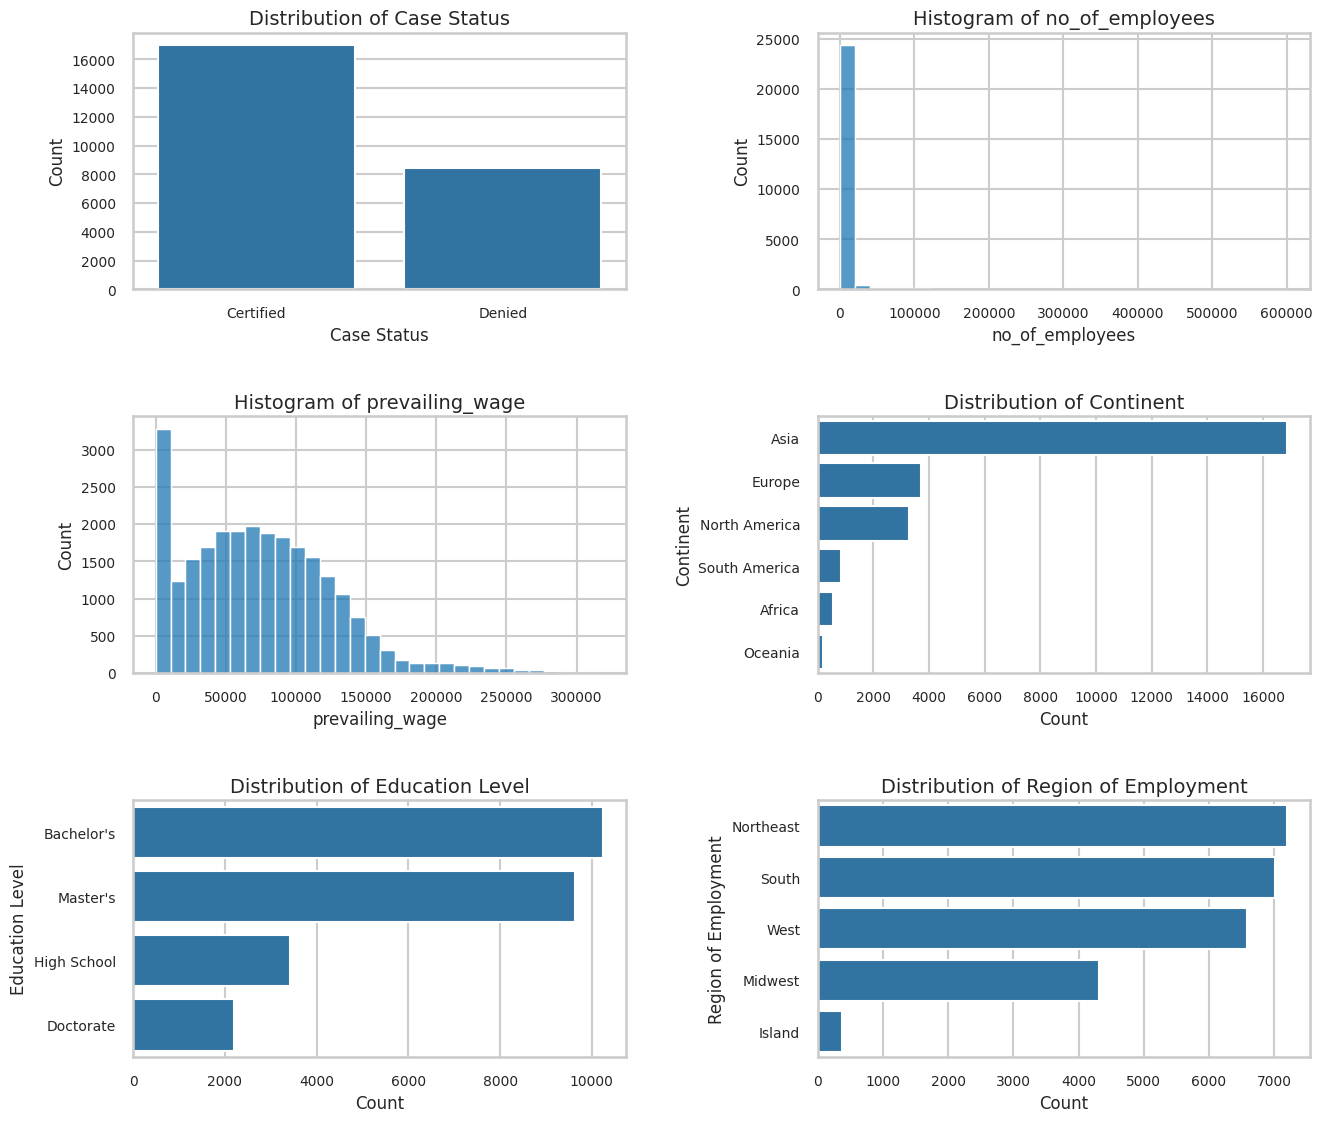

In [52]:
# 3c) Initial EDA

print("--- 3c) Initial EDA ---\n")

# Define font sizes
TITLE_FS = 14
LABEL_FS = 12
TICK_FS  = 10

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1) Distribution of Case Status
sns.countplot(
    data=df, x='case_status',
    order=df['case_status'].value_counts().index,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Distribution of Case Status', fontsize=TITLE_FS)
axes[0, 0].set_xlabel('Case Status', fontsize=LABEL_FS)
axes[0, 0].set_ylabel('Count', fontsize=LABEL_FS)
axes[0, 0].tick_params(axis='both', labelsize=TICK_FS)

# 2) no_of_employees Histogram
sns.histplot(
    df['no_of_employees'], bins=30,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Histogram of no_of_employees', fontsize=TITLE_FS)
axes[0, 1].set_xlabel('no_of_employees', fontsize=LABEL_FS)
axes[0, 1].set_ylabel('Count', fontsize=LABEL_FS)
axes[0, 1].tick_params(axis='both', labelsize=TICK_FS)

# 3) prevailing_wage Histogram
sns.histplot(
    df['prevailing_wage'], bins=30,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Histogram of prevailing_wage', fontsize=TITLE_FS)
axes[1, 0].set_xlabel('prevailing_wage', fontsize=LABEL_FS)
axes[1, 0].set_ylabel('Count', fontsize=LABEL_FS)
axes[1, 0].tick_params(axis='both', labelsize=TICK_FS)

# 4) Continent Distribution
sns.countplot(
    data=df, y='continent',
    order=df['continent'].value_counts().index,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Distribution of Continent', fontsize=TITLE_FS)
axes[1, 1].set_xlabel('Count', fontsize=LABEL_FS)
axes[1, 1].set_ylabel('Continent', fontsize=LABEL_FS)
axes[1, 1].tick_params(axis='both', labelsize=TICK_FS)

# 5) Education Level Distribution
sns.countplot(
    data=df, y='education_of_employee',
    order=df['education_of_employee'].value_counts().index,
    ax=axes[2, 0]
)
axes[2, 0].set_title('Distribution of Education Level', fontsize=TITLE_FS)
axes[2, 0].set_xlabel('Count', fontsize=LABEL_FS)
axes[2, 0].set_ylabel('Education Level', fontsize=LABEL_FS)
axes[2, 0].tick_params(axis='both', labelsize=TICK_FS)

# 6) Region of Employment Distribution
sns.countplot(
    data=df, y='region_of_employment',
    order=df['region_of_employment'].value_counts().index,
    ax=axes[2, 1]
)
axes[2, 1].set_title('Distribution of Region of Employment', fontsize=TITLE_FS)
axes[2, 1].set_xlabel('Count', fontsize=LABEL_FS)
axes[2, 1].set_ylabel('Region of Employment', fontsize=LABEL_FS)
axes[2, 1].tick_params(axis='both', labelsize=TICK_FS)

plt.tight_layout()
plt.show()

**Observations**
* The plots show that approvals are roughly twice as common as denials.
* Employee count and wages are highly right-skewed.
* A typical applicant is university-educated and from Asia.

# 4) Data Cleaning & Feature Engineering

## 4a) Handle Data Errors

Quick analysis on negative employee count

In [36]:
neg_count = (df['no_of_employees'] < 0).sum()
print(f"Negative no_of_employees count: {neg_count}")

Negative no_of_employees count: 33


**Observations**
* If only a few rows, I'd assume data entry error.
* As it's 33 rows, I'll impute median.

Imputing median for negative no_of_employees

In [37]:
# 4a) Handle Data Errors

# 1. Mark negatives as NaN
df.loc[df['no_of_employees'] < 0, 'no_of_employees'] = np.nan

# 2. Compute median from the remaining (non-negative) values
median_emp = df['no_of_employees'].median()
print(f"Imputing {median_emp:.0f} for all negative entries.")

# 3. Fill NaNs with the median
df['no_of_employees'].fillna(median_emp, inplace=True)

# 4. Verify
print("Post-imputation min/max:", df['no_of_employees'].min(), "/", df['no_of_employees'].max())
print("Remaining missing values:", df['no_of_employees'].isnull().sum())

Imputing 2112 for all negative entries.
Post-imputation min/max: 12.0 / 602069.0
Remaining missing values: 0


## 4b) Engineer Annual Wage Feature

In [38]:
# 4b) Engineer Annual Wage Feature

# Define mapping
wage_multiplier_map = {
    'Hour': 2080,
    'Week': 52,
    'Month': 12,
    'Year': 1
}

# Map to a new multiplier column
df['wage_multiplier'] = df['unit_of_wage'].map(wage_multiplier_map)

# Compute annual wage and drop extra column
df['annual_wage'] = df['prevailing_wage'] * df['wage_multiplier']
df.drop(columns=['wage_multiplier'], inplace=True)

# Detailed verification
print("Descriptive stats for 'annual_wage':")
display(df['annual_wage'].describe())

print("\nSample of original vs. annual wage:")
display(df[['prevailing_wage', 'unit_of_wage', 'annual_wage']].head())

Descriptive stats for 'annual_wage':


,annual_wage
count,2.548000e+04
mean,1.973912e+05
std,5.785917e+05
min,1.000000e+02
25%,4.710796e+04
50%,8.283946e+04
75%,1.248250e+05
max,1.456915e+07



Sample of original vs. annual wage:


,prevailing_wage,unit_of_wage,annual_wage
0,592.2029,Hour,1231782.032
1,83425.6500,Year,83425.650
2,122996.8600,Year,122996.860
3,83434.0300,Year,83434.030
4,149907.3900,Year,149907.390


## 4c) Engineer Company Age Feature

In [39]:
# 4c) Engineer Company Age Feature
# Create a feature for the age of the company at the time of application (2016).

# Compute company_age
df['company_age'] = 2016 - df['yr_of_estab']

print("Successfully created the 'company_age' column.\n")

# Detailed summary
print("Descriptive statistics for 'company_age':")
display(df['company_age'].describe())

# Preview the transformation
print("\nPreview of original vs. new age columns:")
display(df[['yr_of_estab', 'company_age']].head())

Successfully created the 'company_age' column.

Descriptive statistics for 'company_age':


,company_age
count,25480.000000
mean,36.590071
std,42.366929
min,0.000000
25%,11.000000
50%,19.000000
75%,40.000000
max,216.000000



Preview of original vs. new age columns:


,yr_of_estab,company_age
0,2007,9
1,2002,14
2,2008,8
3,1897,119
4,2005,11


## 4d) Final Data Cleanup

In [40]:
# 4d) Final Data Cleanup

# Columns to drop
cols_to_drop = ['case_id', 'yr_of_estab', 'prevailing_wage', 'unit_of_wage']
existing = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=existing, inplace=True)

print(f"Dropped columns: {existing}")
print("Remaining columns:")
print(df.columns.tolist())
print(df.shape)

Dropped columns: ['case_id', 'yr_of_estab', 'prevailing_wage', 'unit_of_wage']
Remaining columns:
['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'region_of_employment', 'full_time_position', 'case_status', 'annual_wage', 'company_age']
(25480, 10)


# 5) Detailed EDA

## 5a) Numerical Feature Analysis

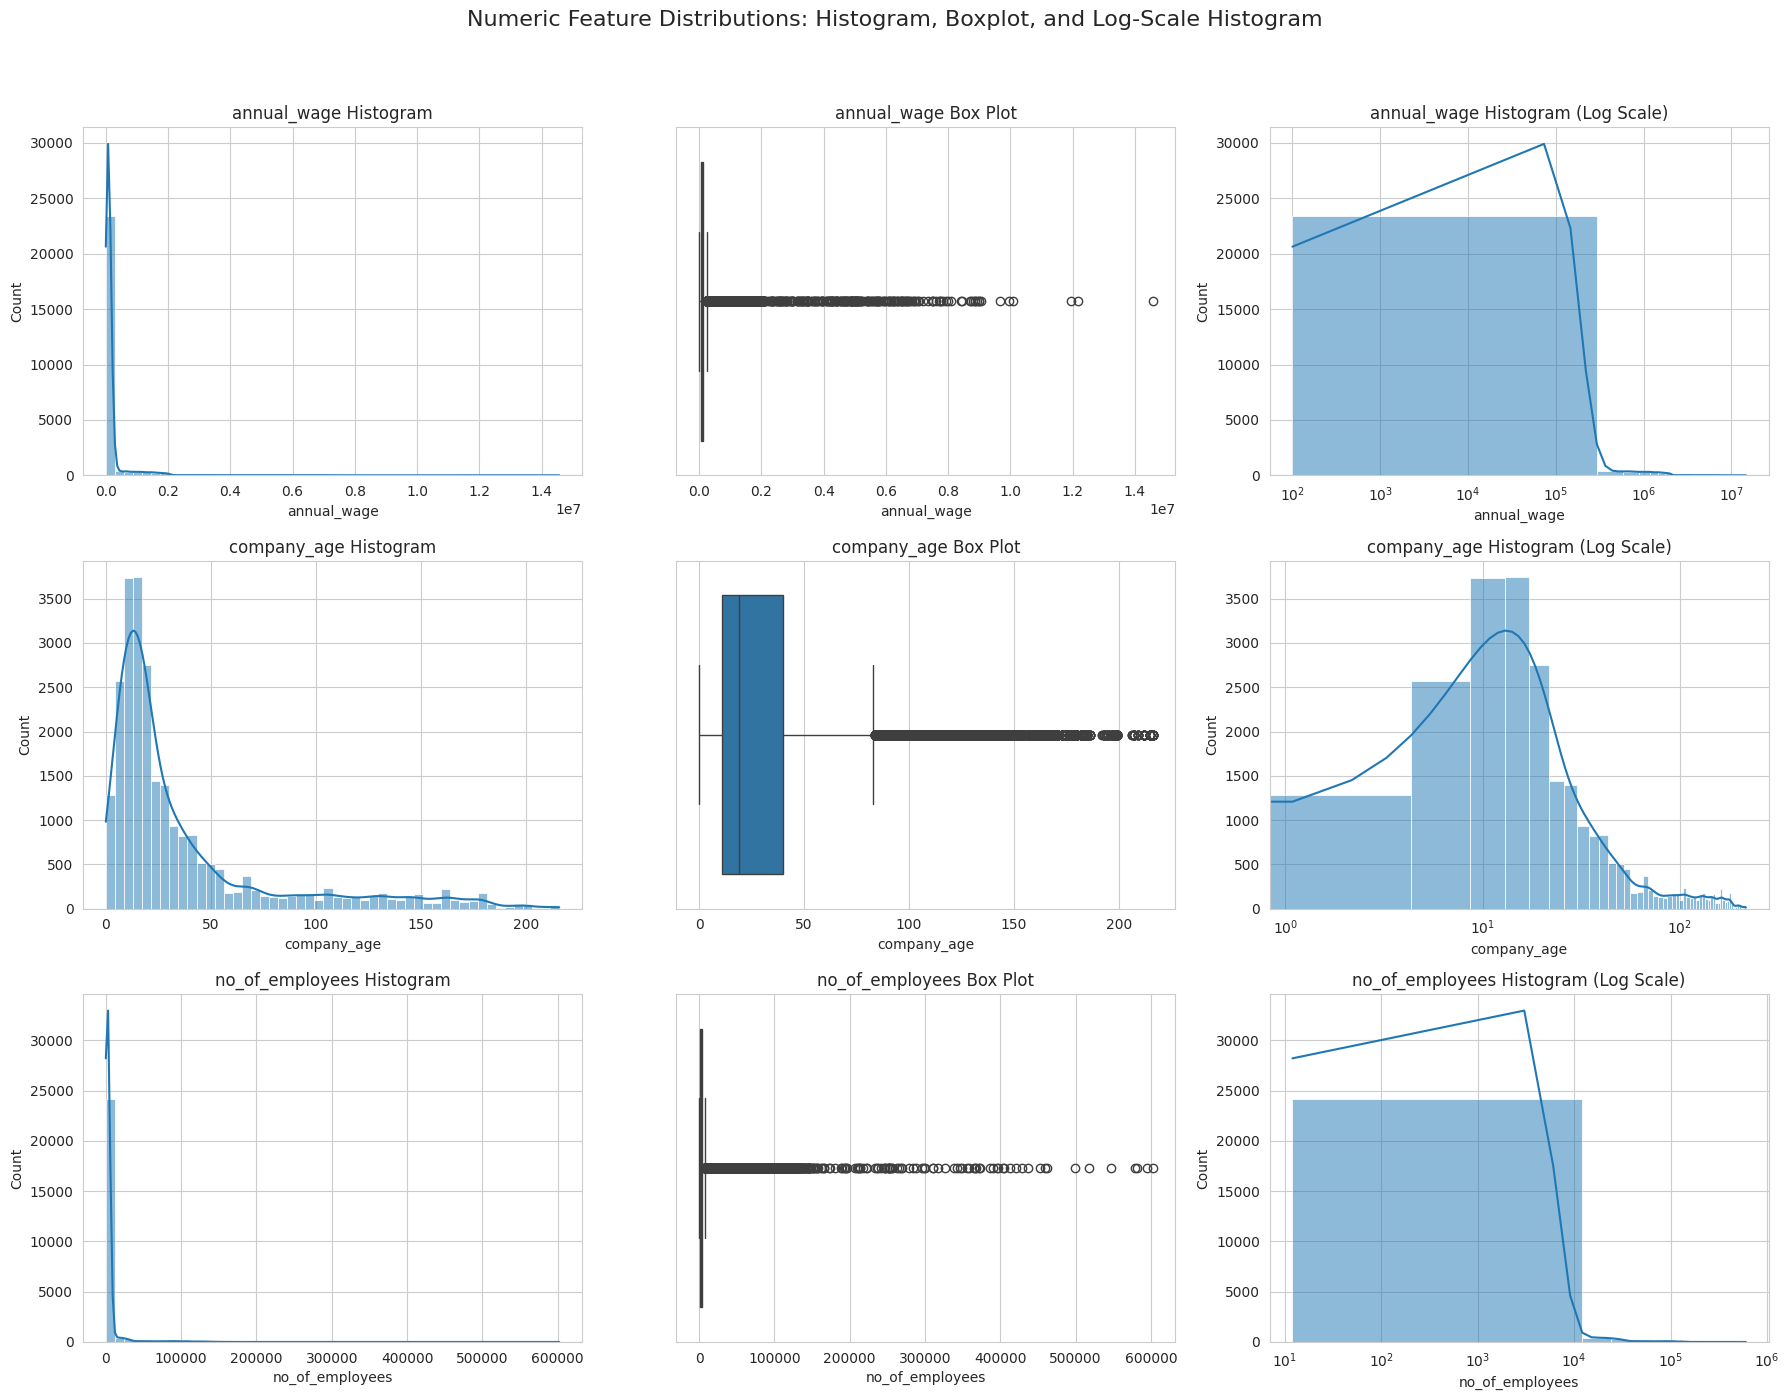

In [41]:
# 5a) Numerical Feature Analysis

numerical_cols = ['annual_wage', 'company_age', 'no_of_employees']
fig, axes = plt.subplots(len(numerical_cols), 3, figsize=(18, 15))
fig.suptitle('Numeric Feature Distributions: Histogram, Boxplot, and Log-Scale Histogram',
             fontsize=16, y=0.93)

for i, col in enumerate(numerical_cols):
    data = df[col].dropna()

    # Standard Histogram
    sns.histplot(data, bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} Histogram')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # Box Plot
    sns.boxplot(x=data, ax=axes[i, 1], showfliers=True)
    axes[i, 1].set_title(f'{col} Box Plot')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('')

    # Log-Scale Histogram
    sns.histplot(data, bins=50, kde=True, ax=axes[i, 2])
    axes[i, 2].set_xscale('log')
    axes[i, 2].set_title(f'{col} Histogram (Log Scale)')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()

**Observations**
* Annual_wage and no_of_employees are highly right-skewed. We will log-transform these.
* Company age is more spread out. We will leave this as-is.
* Since outliers are real data, we'll leave them as-is.

## 5b) Categorical Feature Analysis

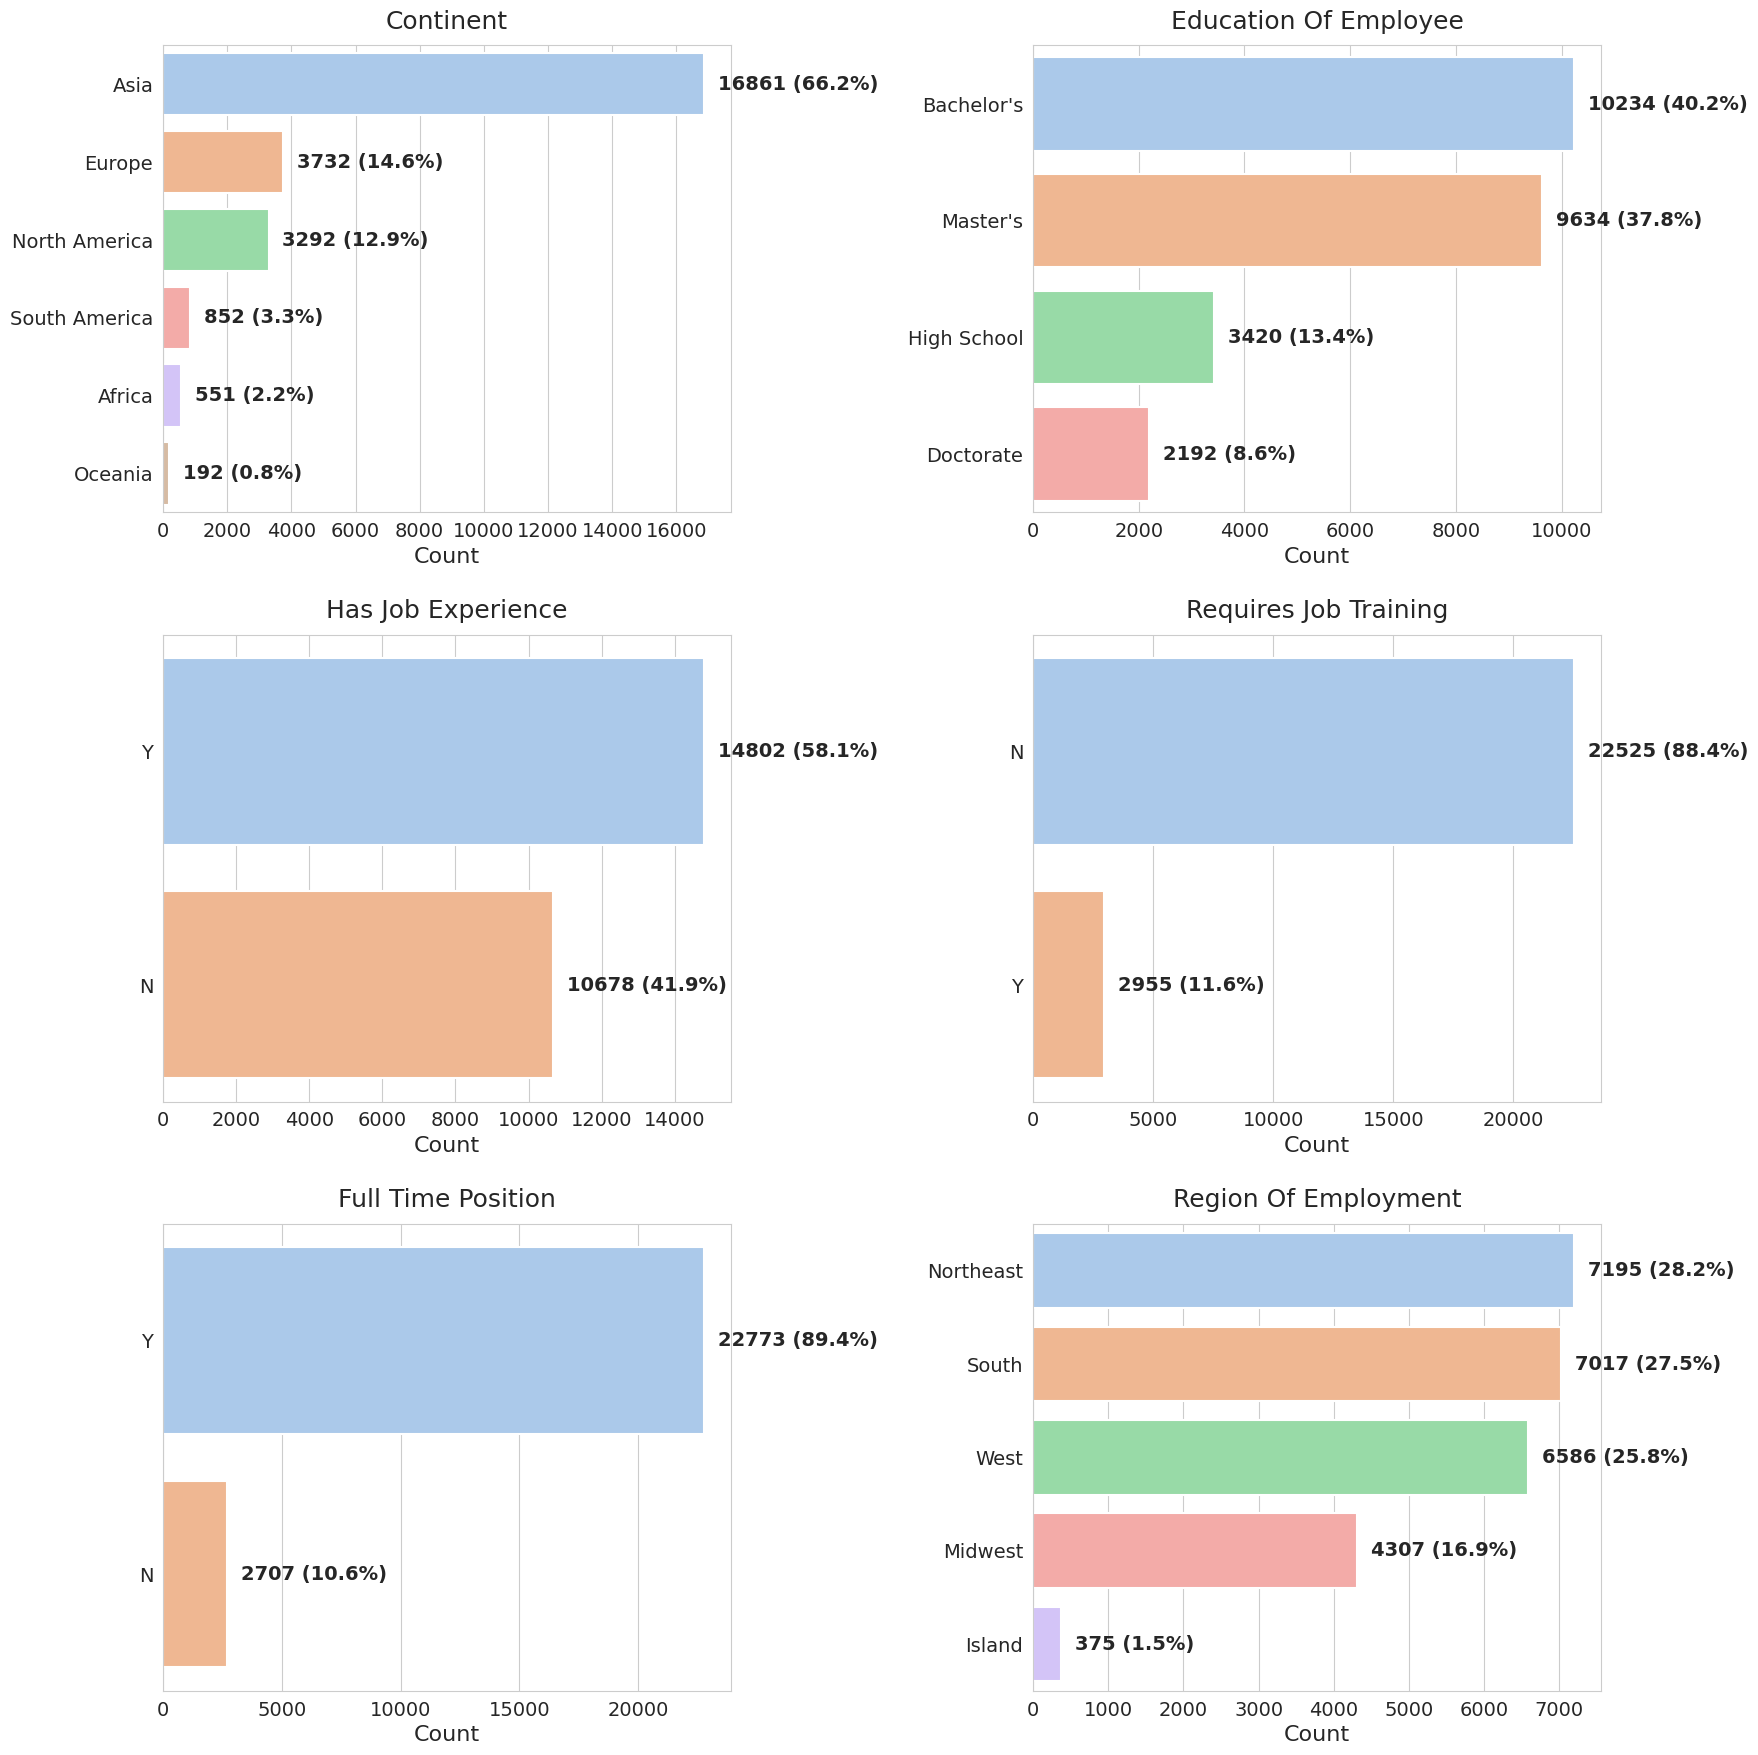

In [42]:
# 5c) Categorical Feature Analysis

# Define categorical features
categorical_features = [
    'continent',
    'education_of_employee',
    'has_job_experience',
    'requires_job_training',
    'full_time_position',
    'region_of_employment'
]

# Set up a 3×2 grid
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()
total = len(df)

# Increase overall font scale
sns.set_context("talk", font_scale=1.2)

# Plot each feature
for ax, col in zip(axes, categorical_features):
    counts = df[col].value_counts()
    sns.barplot(
        x=counts.values,
        y=counts.index,
        ax=ax,
        palette='pastel'
    )
    ax.set_title(col.replace('_', ' ').title(), fontsize=18, pad=12)
    ax.set_xlabel('Count', fontsize=16)
    ax.set_ylabel('', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Annotate bars with count and percentage
    for p in ax.patches:
        count = int(p.get_width())
        pct = count / total * 100
        ax.annotate(
            f"{count} ({pct:.1f}%)",
            xy=(p.get_width(), p.get_y() + p.get_height()/2),
            xytext=(10, 0),
            textcoords='offset points',
            va='center',
            fontsize=14,
            fontweight='bold'
        )

plt.tight_layout()
plt.show()

**Observations**
* About two-thirds of applicants are from Asia, with Europe and North America next.
* Roughly 40% Bachelor’s and 38% Master’s.
* Job Experience & Training: Most applicants have experience and do not require training.
* A vast majority of cases are for full-time roles.

## 5c) Bivariate Analysis

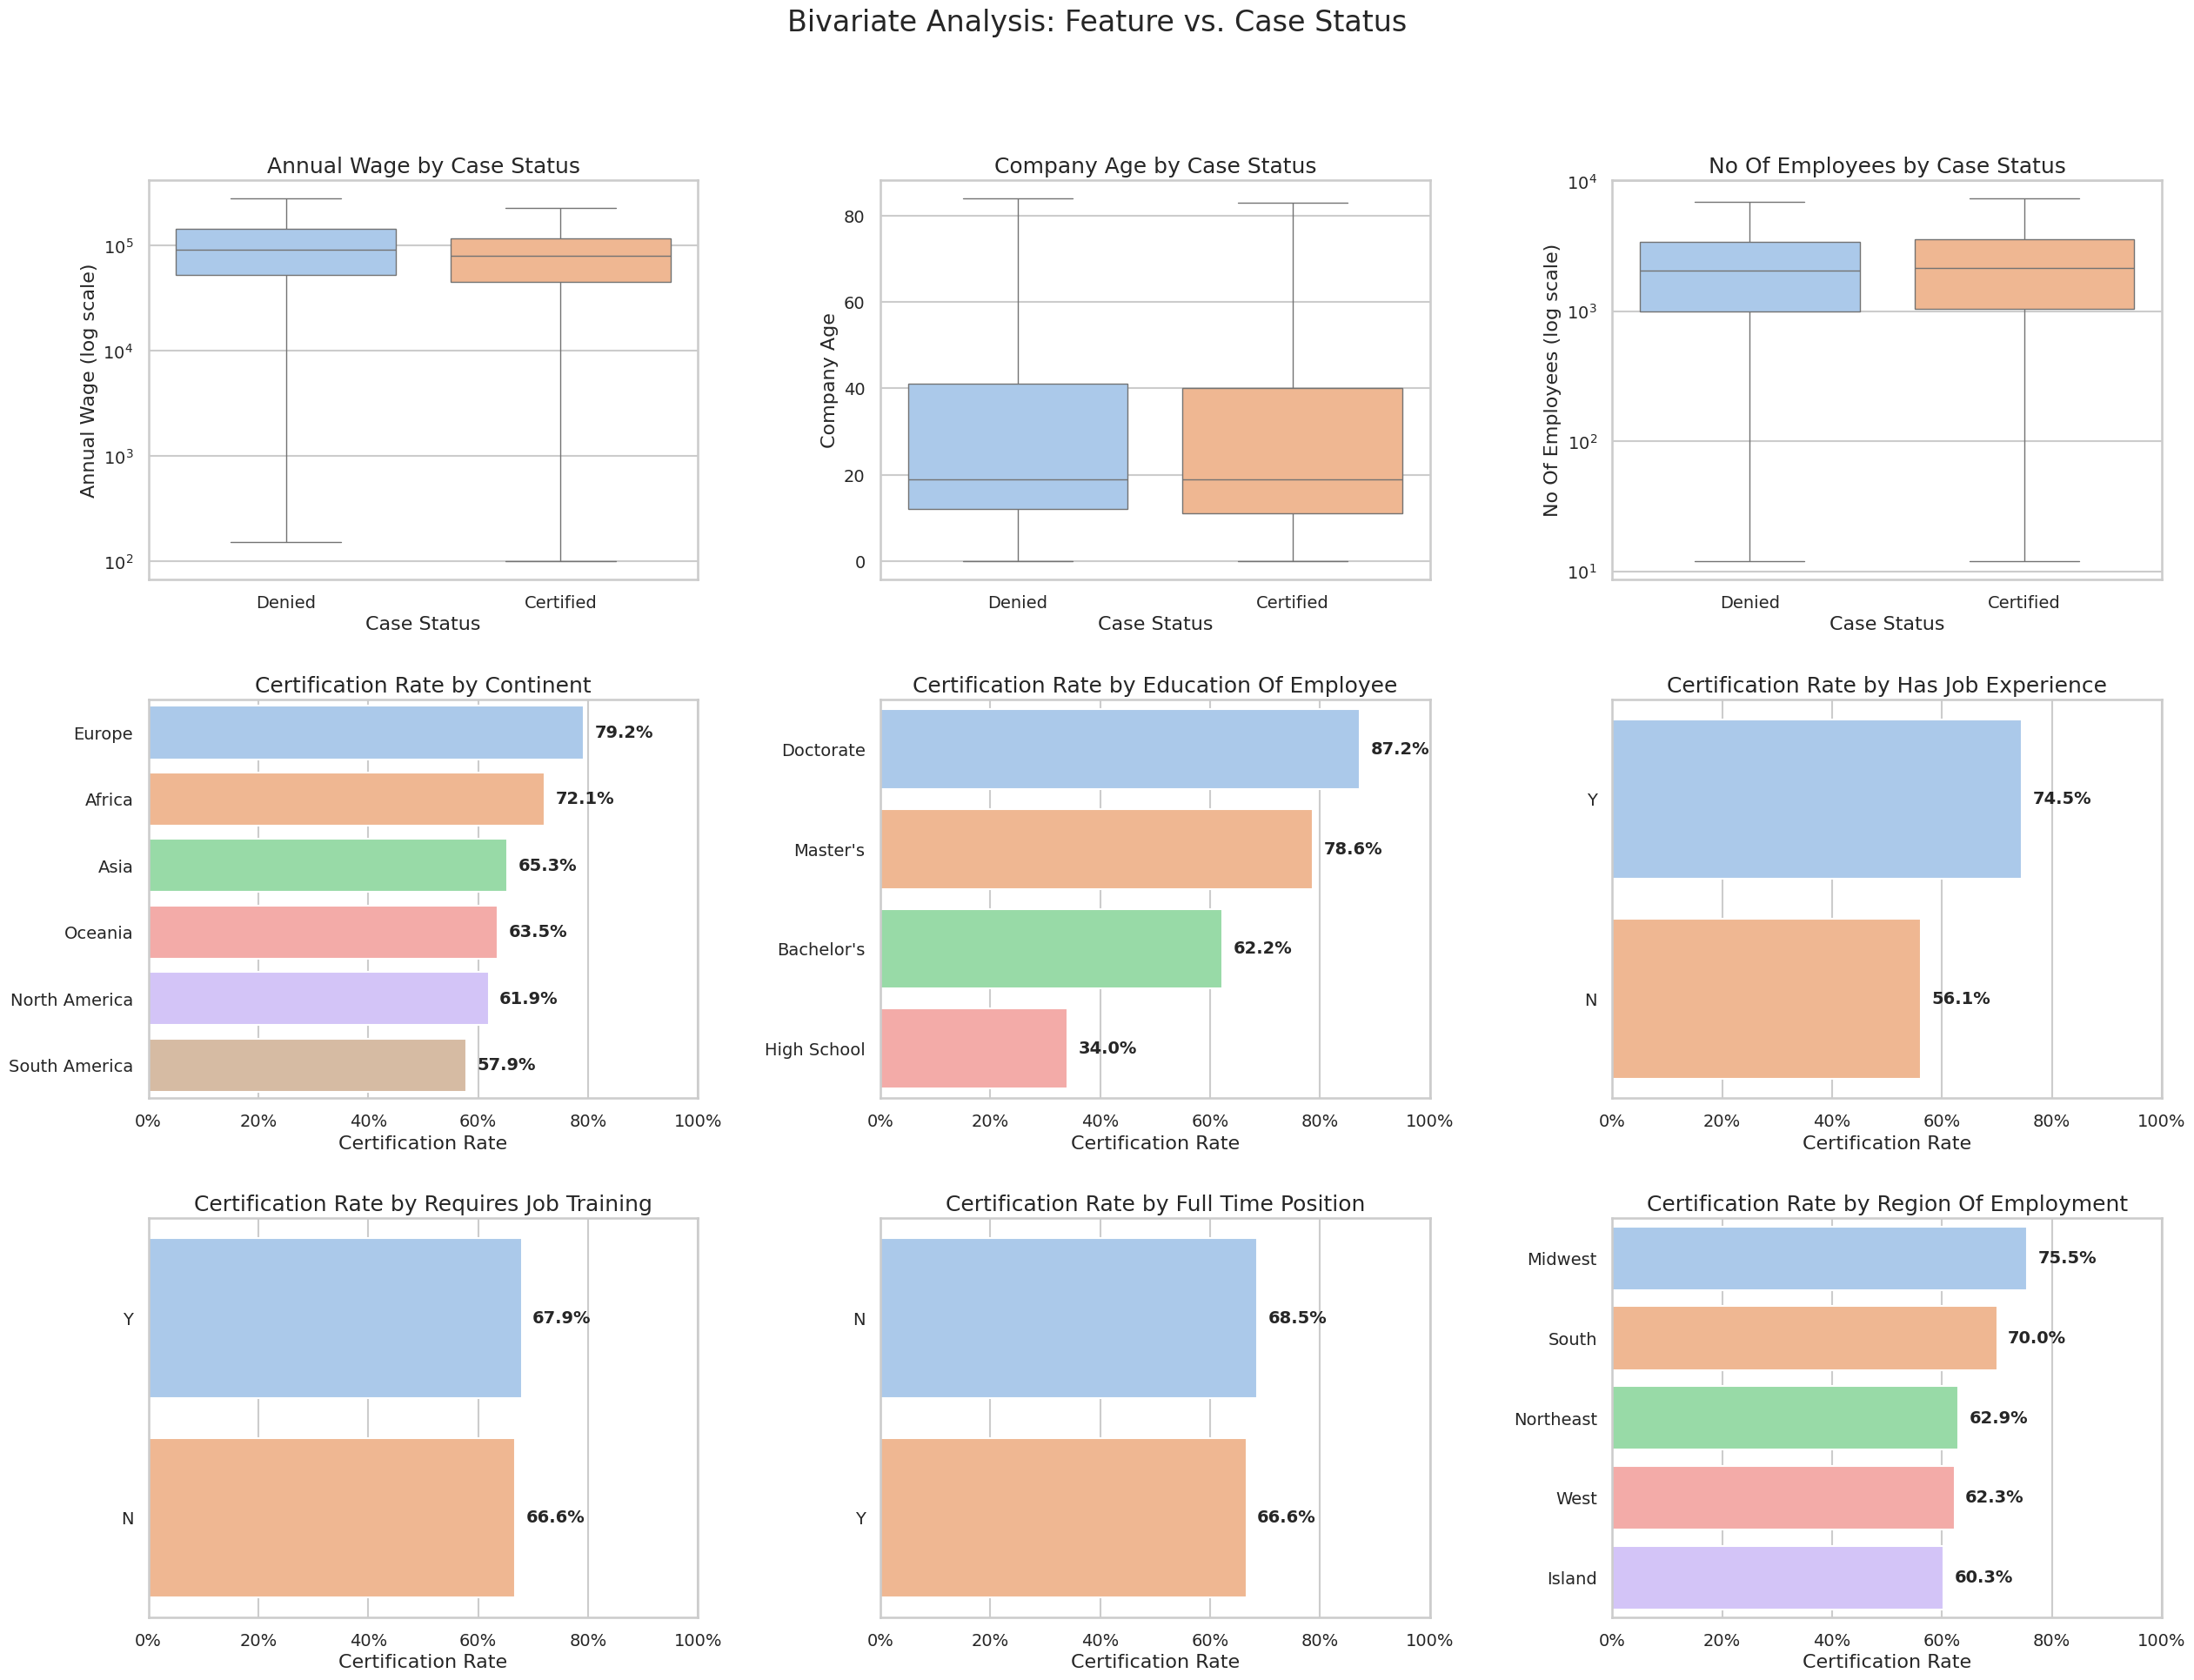

In [43]:
# 5d) Bivariate Analysis

# Increase overall context for larger text
sns.set_context("talk", font_scale=1.8)

# Define feature lists
numerical_cols = ['annual_wage', 'company_age', 'no_of_employees']
categorical_cols = [
    'continent',
    'education_of_employee',
    'has_job_experience',
    'requires_job_training',
    'full_time_position',
    'region_of_employment'
]

fig, axes = plt.subplots(3, 3, figsize=(26, 20))
axes = axes.flatten()
fig.suptitle('Bivariate Analysis: Feature vs. Case Status', fontsize=24, y=0.98)

# Numeric features by case_status
for ax, col in zip(axes[:3], numerical_cols):
    sns.boxplot(
        x='case_status', y=col, data=df,
        ax=ax, palette='pastel', showfliers=False
    )
    ax.set_title(f'{col.replace("_", " ").title()} by Case Status', fontsize=18)
    ax.set_xlabel('Case Status', fontsize=16)
    ylabel = col.replace("_", " ").title()
    if col in ['annual_wage', 'no_of_employees']:
        ax.set_yscale('log')
        ylabel += " (log scale)"
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

# Certification rate by categorical feature
for ax, col in zip(axes[3:], categorical_cols):
    rate = (
        df.assign(is_cert=(df['case_status']=='Certified').astype(int))
          .groupby(col)['is_cert']
          .mean()
          .sort_values(ascending=False)
    )
    sns.barplot(
        x=rate.values, y=rate.index,
        ax=ax, palette='pastel'
    )
    ax.set_title(f'Certification Rate by {col.replace("_", " ").title()}', fontsize=18)
    ax.set_xlabel('Certification Rate', fontsize=16)
    ax.set_ylabel('', fontsize=16)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_xlim(0, 1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Annotate bars
    for p in ax.patches:
        pct = p.get_width()
        ax.text(
            pct + 0.02,
            p.get_y() + p.get_height() / 2,
            f'{pct:.1%}',
            va='center',
            fontsize=14,
            fontweight='bold'
        )

# Hide any unused axes
for ax in axes[len(numerical_cols) + len(categorical_cols):]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Observations**
* Approval rate climbs steadily with each level of education.
* Applicants with prior job experience have a much higher approval rate than those without.
* Higher annual wages and full-time positions are both associated with a higher approval ratel.
* Continent of origin is also a major factor.
* Company age and job training don't seem to impact approval rates much.

## 5d) Correlation Heatmap

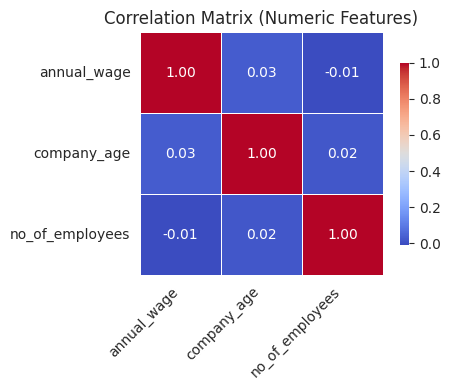

In [31]:
# 5d) Correlation Heatmap

# Final numerical features
numerical_cols = ['annual_wage', 'company_age', 'no_of_employees']

# Compute correlation matrix
corr = df[numerical_cols].corr()

# Compact heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.75}
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Matrix (Numeric Features)", fontsize=12)
plt.tight_layout()
plt.show()

**Observations**
* There is little correlation between annual_wage, company_age, and no_of_employees.

# 6) Data Preprocessing

## 6a) Define Features and Target  

In [14]:
# 6a) Define Features and Target

# Encode target as binary
y = df['case_status'].map({'Certified': 1, 'Denied': 0})

# Drop target to form feature matrix
X = df.drop(columns=['case_status'])

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (25480, 9)
Target distribution:
 case_status
1    0.667896
0    0.332104
Name: proportion, dtype: float64


## 6b) Split into Train/Test Sets

In [15]:
# 6b) Split into Train/Test Sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Training set:", X_train.shape, y_train.value_counts(normalize=True).to_dict())
print("  Test set:", X_test.shape, y_test.value_counts(normalize=True).to_dict())

Training set: (17836, 9) {1: 0.6679188158779995, 0: 0.33208118412200044}
  Test set: (7644, 9) {1: 0.6678440607012036, 0: 0.33215593929879644}


## 6c) Build Preprocessing Pipeline

In [16]:
# 6c) Build Preprocessing Pipeline

# Numeric features
num_features = ['annual_wage', 'company_age', 'no_of_employees']
num_pipeline = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, validate=False)),
    ('robust_scaler', RobustScaler())
])

# Ordinal encode education
# Define the rank order explicitly
edu_order = ["High School", "Bachelor's", "Master's", "Doctorate"]
ord_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[edu_order], dtype=int))
])

# One-hot for the rest
cat_features = [
    'continent',
    'region_of_employment',
    'has_job_experience',
    'requires_job_training',
    'full_time_position'
]
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('edu', ord_pipeline, ['education_of_employee']),
    ('cat', cat_pipeline, cat_features)
], remainder='drop', verbose_feature_names_out=False)

# Quick check: fit and transform a small slice
preprocessor.fit(X_train)
Xt_sample = preprocessor.transform(X_train.iloc[:5])
print("Transformed feature shape (sample):", Xt_sample.shape)

Transformed feature shape (sample): (5, 16)


# 7) General Model Testing

## 7a) Model Evaluation Criterion

* F1-Score: This will be our main score. It's a single number that measures a model's ability to find qualified applicants without making too many mistakes along the way. It fits well with the imbalanced data.
* ROC AUC Score: This will be a secondary score, showing how well the model can distinguish between an approved application and a denied one. A higher score means the model is better at telling the two groups apart.

My approach will be to run baselines on 14 different models:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* KNeighborsClassifier
* GaussianNB
* Support Vector Classifier
* SGDClassifier
* RandomForestClassifier
* ExtraTreesClassifier
* AdaBoostClassifier
* HistGradientBoostingClassifier
* XGBoostClassifier
* LightGBMClassifier
* CatBoostClassifier

Based on scores, I will hypertune the top 4 performers using Optuna. Next, I will see how voting and stacking ensembles work with the top 3 models to attempt to squeeze out a few more points. From there, I'll choose a model.

## 7b) Model Evaluation Functions

In [19]:
# 7b) Model Evaluation Functions

def cross_validate_model(pipeline, X, y, cv=10, scoring=None, n_jobs=-1):
    """
    Perform cross-validation on a model pipeline and return a DataFrame
    summarizing mean and std of key metrics plus timing info.

    Metrics returned (in order):
      - F1
      - ROC AUC
      - Accuracy
      - Precision
      - Recall

    Parameters
    ----------
    pipeline : estimator or Pipeline
        The scikit-learn pipeline or model to evaluate.
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    y : array-like, shape (n_samples,)
        Target vector.
    cv : int or CV splitter, default=10
        Number of folds or CV splitter.
    scoring : list of str, optional
        Scoring metrics to compute. If None, uses
        ['f1', 'roc_auc', 'accuracy', 'precision', 'recall'].
    n_jobs : int, default=-1
        Number of jobs for parallelism.

    Returns
    -------
    cv_results : pandas.DataFrame
        Rows are metrics in the order above, columns are:
        ['mean_test', 'std_test', 'mean_fit_time', 'mean_score_time'].
    """
    if scoring is None:
        scoring = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']

    # Run cross-validation
    cv_dict = cross_validate(
        estimator=pipeline,
        X=X, y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=n_jobs
    )

    # Build results table
    results = []
    for metric in scoring:
        test_key = f'test_{metric}'
        results.append({
            'metric': metric,
            'mean_test':     cv_dict[test_key].mean(),
            'std_test':      cv_dict[test_key].std(),
            'mean_fit_time': cv_dict['fit_time'].mean(),
            'mean_score_time': cv_dict['score_time'].mean()
        })

    cv_results = pd.DataFrame(results).set_index('metric')

    # Print summary in new order
    print(f"Mean F1 Score:       {cv_results.loc['f1', 'mean_test']:.4f} ± {cv_results.loc['f1', 'std_test']:.4f}")
    print(f"Mean ROC AUC:        {cv_results.loc['roc_auc', 'mean_test']:.4f} ± {cv_results.loc['roc_auc', 'std_test']:.4f}")
    print(f"Mean Accuracy:       {cv_results.loc['accuracy', 'mean_test']:.4f} ± {cv_results.loc['accuracy', 'std_test']:.4f}")
    print(f"Mean Precision:      {cv_results.loc['precision', 'mean_test']:.4f} ± {cv_results.loc['precision', 'std_test']:.4f}")
    print(f"Mean Recall:         {cv_results.loc['recall', 'mean_test']:.4f} ± {cv_results.loc['recall', 'std_test']:.4f}")

    return cv_results

def confusion_matrix_sklearn(model, predictors, target, title='Confusion Matrix'):
    """
    To plot the confusion_matrix with percentages and hardcoded font sizes.

    model: classifier
    predictors: independent variables
    target: dependent variable
    title: the title of the plot
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(4, 3))

    # Set font size for stats (annotations) inside the heatmap
    sns.heatmap(cm, annot=labels, fmt="", annot_kws={"size": 10})

    # Set font size for title
    plt.title(title, fontsize=16)

    # Set font size for x and y labels
    plt.ylabel("Actual", fontsize=12)
    plt.xlabel("Predicted", fontsize=12)

    # Set font size for x and y ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

print("Helper functions defined.")

Helper functions defined.


## 7c) Baseline Models

DummyClassifier and LogisticRegression

In [30]:
# 7c) Baseline Models

dummy_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy='most_frequent', random_state=42))
])

print(">>> DummyClassifier (most_frequent) CV results:")
cv_dummy = cross_validate_model(dummy_pipeline, X_train, y_train, cv=10)
print()

log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    ))
])

print(">>> LogisticRegression CV results:")
cv_log = cross_validate_model(log_pipeline, X_train, y_train, cv=10)
print()

baseline_summary = pd.DataFrame({
    'Dummy (maj_class)': cv_dummy['mean_test'],
    'LogReg':            cv_log['mean_test'],
}).T
baseline_summary.columns = cv_dummy.index  # metrics as columns
print("Baseline comparison (mean ± std):")
display(baseline_summary)

>>> DummyClassifier (most_frequent) CV results:
Mean F1 Score:       0.8009 ± 0.0002
Mean ROC AUC:        0.5000 ± 0.0000
Mean Accuracy:       0.6679 ± 0.0002
Mean Precision:      0.6679 ± 0.0002
Mean Recall:         1.0000 ± 0.0000

>>> LogisticRegression CV results:
Mean F1 Score:       0.8103 ± 0.0064
Mean ROC AUC:        0.7567 ± 0.0162
Mean Accuracy:       0.7250 ± 0.0091
Mean Precision:      0.7514 ± 0.0061
Mean Recall:         0.8791 ± 0.0094

Baseline comparison (mean ± std):


metric,f1,roc_auc,accuracy,precision,recall
Dummy (maj_class),0.800901,0.500000,0.667919,0.667919,1.000000
LogReg,0.810250,0.756683,0.724993,0.751419,0.879125


**Observations**
* Dummy model scores 0.50 ROC AUC, which is no better than random guessing.
* Logistic Regression sets a baseline to beat with an F1 of ~.81.

## 7d) Traditional Models

DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, Support Vector Classifier, SGDClassifier

In [31]:
# 7d) Traditional Models

# Define pipelines
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

gnb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='rbf', probability=True, random_state=42))
])

sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(loss='hinge', random_state=42))
])

# Cross-validate each
print(">>> Decision Tree CV results:")
cv_dt  = cross_validate_model(dt_pipeline,  X_train, y_train, cv=10)

print("\n>>> KNN CV results:")
cv_knn = cross_validate_model(knn_pipeline, X_train, y_train, cv=10)

print("\n>>> GaussianNB CV results:")
cv_gnb = cross_validate_model(gnb_pipeline, X_train, y_train, cv=10)

print("\n>>> SVC CV results:")
cv_svc = cross_validate_model(svc_pipeline, X_train, y_train, cv=10)

print("\n>>> SGDClassifier (hinge) CV results:")
cv_sgd = cross_validate_model(sgd_pipeline, X_train, y_train, cv=10)

# Summarize in same format as baseline comparison
traditional_summary = pd.DataFrame({
    'DecisionTree':        cv_dt['mean_test'],
    'KNN':                 cv_knn['mean_test'],
    'GaussianNB':          cv_gnb['mean_test'],
    'SVC':                 cv_svc['mean_test'],
    'SGDClassifier':       cv_sgd['mean_test']
}).T

# Metrics as columns
traditional_summary.columns = cv_dt.index

print("\nTraditional Models Comparison:")
display(traditional_summary)

>>> Decision Tree CV results:
Mean F1 Score:       0.7375 ± 0.0072
Mean ROC AUC:        0.6063 ± 0.0100
Mean Accuracy:       0.6500 ± 0.0088
Mean Precision:      0.7388 ± 0.0071
Mean Recall:         0.7363 ± 0.0106

>>> KNN CV results:
Mean F1 Score:       0.7877 ± 0.0089
Mean ROC AUC:        0.7123 ± 0.0129
Mean Accuracy:       0.7037 ± 0.0118
Mean Precision:      0.7553 ± 0.0075
Mean Recall:         0.8230 ± 0.0121

>>> GaussianNB CV results:
Mean F1 Score:       0.7971 ± 0.0076
Mean ROC AUC:        0.7179 ± 0.0150
Mean Accuracy:       0.7111 ± 0.0105
Mean Precision:      0.7507 ± 0.0085
Mean Recall:         0.8498 ± 0.0131

>>> SVC CV results:
Mean F1 Score:       0.8196 ± 0.0065
Mean ROC AUC:        0.7632 ± 0.0116
Mean Accuracy:       0.7438 ± 0.0091
Mean Precision:      0.7738 ± 0.0063
Mean Recall:         0.8711 ± 0.0086

>>> SGDClassifier (hinge) CV results:
Mean F1 Score:       0.8063 ± 0.0067
Mean ROC AUC:        0.7472 ± 0.0142
Mean Accuracy:       0.7156 ± 0.0076
Mean Preci

metric,f1,roc_auc,accuracy,precision,recall
DecisionTree,0.737524,0.606309,0.649978,0.738793,0.736339
KNN,0.787684,0.712281,0.703688,0.755271,0.823049
GaussianNB,0.797146,0.717914,0.711144,0.750744,0.849828
SVC,0.819566,0.763243,0.743833,0.773842,0.871066
SGDClassifier (hinge),0.806293,0.747247,0.715575,0.739813,0.886839


**Observations**
* SVC did significantly better than our baseline and the rest of the traditional models.

## 7e) Ensemble Models

RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, XGBoostClassifier, LightGBMClassifier, CatBoostClassifier

In [29]:
# 7e) Ensemble Models

# Define pipelines
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(use_label_encoder=False,
                                 eval_metric='logloss',
                                 random_state=42))
])

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(random_state=42))
])

cb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(verbose=0, random_state=42))
])

ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier(random_state=42))
])

et_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ExtraTreesClassifier(random_state=42))
])

hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', HistGradientBoostingClassifier(random_state=42))
])

# Cross-validate each
print(">>> Random Forest CV results:")
cv_rf  = cross_validate_model(rf_pipeline,  X_train, y_train, cv=10)

print("\n>>> XGBoost CV results:")
cv_xgb = cross_validate_model(xgb_pipeline, X_train, y_train, cv=10)

print("\n>>> LightGBM CV results:")
cv_lgb = cross_validate_model(lgb_pipeline, X_train, y_train, cv=10)

print("\n>>> CatBoost CV results:")
cv_cb  = cross_validate_model(cb_pipeline, X_train, y_train, cv=10)

print("\n>>> AdaBoost CV results:")
cv_ada = cross_validate_model(ada_pipeline, X_train, y_train, cv=10)

print("\n>>> ExtraTrees CV results:")
cv_et  = cross_validate_model(et_pipeline,  X_train, y_train, cv=10)

print("\n>>> HistGradientBoosting CV results:")
cv_hgb = cross_validate_model(hgb_pipeline, X_train, y_train, cv=10)

# Summarize mean_test scores side-by-side
ensemble_summary = pd.DataFrame({
    'RandomForest':          cv_rf['mean_test'],
    'XGBoost':               cv_xgb['mean_test'],
    'LightGBM':              cv_lgb['mean_test'],
    'CatBoost':              cv_cb['mean_test'],
    'AdaBoost':              cv_ada['mean_test'],
    'ExtraTrees':            cv_et['mean_test'],
    'HistGradientBoosting':  cv_hgb['mean_test']
}).T

ensemble_summary.columns = cv_rf.index  # align metric names

print("\nEnsemble & Boosting Comparison (mean_test scores):")
display(ensemble_summary)

>>> Random Forest CV results:
Mean F1 Score:       0.8017 ± 0.0077
Mean ROC AUC:        0.7532 ± 0.0103
Mean Accuracy:       0.7235 ± 0.0111
Mean Precision:      0.7695 ± 0.0084
Mean Recall:         0.8367 ± 0.0078

>>> XGBoost CV results:
Mean F1 Score:       0.8064 ± 0.0077
Mean ROC AUC:        0.7614 ± 0.0097
Mean Accuracy:       0.7274 ± 0.0107
Mean Precision:      0.7672 ± 0.0070
Mean Recall:         0.8497 ± 0.0092

>>> LightGBM CV results:
Mean F1 Score:       0.8182 ± 0.0066
Mean ROC AUC:        0.7797 ± 0.0095
Mean Accuracy:       0.7432 ± 0.0093
Mean Precision:      0.7760 ± 0.0066
Mean Recall:         0.8652 ± 0.0078

>>> CatBoost CV results:
Mean F1 Score:       0.8185 ± 0.0072
Mean ROC AUC:        0.7796 ± 0.0114
Mean Accuracy:       0.7430 ± 0.0104
Mean Precision:      0.7749 ± 0.0080
Mean Recall:         0.8672 ± 0.0086

>>> AdaBoost CV results:
Mean F1 Score:       0.8163 ± 0.0053
Mean ROC AUC:        0.7653 ± 0.0137
Mean Accuracy:       0.7344 ± 0.0076
Mean Precision: 

metric,f1,roc_auc,accuracy,precision,recall
RandomForest,0.801711,0.753184,0.723535,0.769520,0.836732
XGBoost,0.806351,0.761407,0.727405,0.767186,0.849745
LightGBM,0.818177,0.779664,0.743159,0.776025,0.865189
CatBoost,0.818463,0.779593,0.743047,0.774945,0.867206
AdaBoost,0.816312,0.765298,0.734412,0.758612,0.883574
ExtraTrees,0.790923,0.741630,0.711033,0.765313,0.818351
HistGradientBoosting,0.819987,0.781169,0.745907,0.778278,0.866450


**Observations**
* Ensemble models showed improvement, with HGB, CatBoost, and LightGBM leading the pack.

## 7f) Comparison of All Models

In [32]:
# 7f) Comparison of All Models (including the new additions)

import pandas as pd

# Compile mean_test scores for all evaluated models
all_models_results = {
    'Dummy':                   cv_dummy['mean_test'],
    'LogisticRegression':      cv_log['mean_test'],
    'DecisionTree':            cv_dt['mean_test'],
    'KNN':                     cv_knn['mean_test'],
    'GaussianNB':              cv_gnb['mean_test'],
    'SVC':                     cv_svc['mean_test'],
    'SGDClassifier':           cv_sgd['mean_test'],
    'RandomForest':            cv_rf['mean_test'],
    'ExtraTrees':              cv_et['mean_test'],
    'AdaBoost':                cv_ada['mean_test'],
    'HistGradientBoosting':    cv_hgb['mean_test'],
    'XGBoost':                 cv_xgb['mean_test'],
    'LightGBM':                cv_lgb['mean_test'],
    'CatBoost':                cv_cb['mean_test']
}

# Create a DataFrame and align columns
comparison_df = pd.DataFrame(all_models_results).T
comparison_df.columns = cv_dummy.index  # use metric names from any cv_x

# Sort by F1 score in descending order
comparison_df = comparison_df.sort_values('f1', ascending=False)

print("Comparison of All Models (mean_test scores):")
display(comparison_df)

Comparison of All Models (mean_test scores):


metric,f1,roc_auc,accuracy,precision,recall
HistGradientBoosting,0.819987,0.781169,0.745907,0.778278,0.866450
SVC,0.819566,0.763243,0.743833,0.773842,0.871066
CatBoost,0.818463,0.779593,0.743047,0.774945,0.867206
LightGBM,0.818177,0.779664,0.743159,0.776025,0.865189
AdaBoost,0.816312,0.765298,0.734412,0.758612,0.883574
LogisticRegression,0.810250,0.756683,0.724993,0.751419,0.879125
XGBoost,0.806351,0.761407,0.727405,0.767186,0.849745
SGDClassifier,0.806293,0.747247,0.715575,0.739813,0.886839
RandomForest,0.801711,0.753184,0.723535,0.769520,0.836732
Dummy,0.800901,0.500000,0.667919,0.667919,1.000000


**Observations**
* SVC, CatBoost, HGB, and LightGBM are winners, based on our primary and secondary metrics.
* Next, we'll hypertune each with Optuna.

# 8) Model Hypertuning

## 8a) LightGBM Hypertuning

In [ ]:
# 8a) LightGBM Hypertuning

def lgbm_optuna_objective(trial):
    # Suggest hyperparameters
    params = {
        'num_leaves':        trial.suggest_int('num_leaves',        31, 512),
        'max_depth':         trial.suggest_int('max_depth',         5,  50),
        'learning_rate':     trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'n_estimators':      trial.suggest_int('n_estimators',      100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5,  200),
        'subsample':         trial.suggest_float('subsample',        0.5, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha':         trial.suggest_loguniform('reg_alpha',    1e-8, 10.0),
        'reg_lambda':        trial.suggest_loguniform('reg_lambda',   1e-8, 10.0),
        'random_state':      42,
        'n_jobs':           -1
    }

    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',        LGBMClassifier(**params))
    ])

    # 3-fold CV with selected metrics
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )

    # Aggregate test means
    f1_mean      = results['test_f1'].mean()
    roc_auc_mean = results['test_roc_auc'].mean()
    acc_mean     = results['test_accuracy'].mean()
    prec_mean    = results['test_precision'].mean()
    rec_mean     = results['test_recall'].mean()

    # Log secondary metrics
    trial.set_user_attr('roc_auc',   roc_auc_mean)
    trial.set_user_attr('accuracy',  acc_mean)
    trial.set_user_attr('precision', prec_mean)
    trial.set_user_attr('recall',    rec_mean)
    trial.set_user_attr('timestamp', datetime.now().isoformat())

    # Return F1 as objective
    return f1_mean

# Create and run the Optuna study
study_lgbm = optuna.create_study(
    direction='maximize',
    study_name='LGBM_F1_Optimization'
)
study_lgbm.optimize(
    lgbm_optuna_objective,
    n_trials=50,
    show_progress_bar=True
)

# Report best results
print(f"Best F1 Score: {study_lgbm.best_value:.4f}")
print("Best hyperparameters:")
for k, v in study_lgbm.best_params.items():
    print(f"  {k}: {v}")

# Display top 5 trials by F1 with secondary metrics
records = []
for t in study_lgbm.trials:
    records.append({
        'trial':      t.number,
        'f1':         t.value,
        'roc_auc':    t.user_attrs['roc_auc'],
        'accuracy':   t.user_attrs['accuracy'],
        'precision':  t.user_attrs['precision'],
        'recall':     t.user_attrs['recall']
    })

df_lgbm_trials = pd.DataFrame(records)
top5_lgbm = df_lgbm_trials.nlargest(5, 'f1')[
    ['trial', 'f1', 'roc_auc', 'accuracy', 'precision', 'recall']
]

print("\nTop 5 LightGBM Trials (by F1):")
display(top5_lgbm)

(note - output cleared because progress widget doesn't export to HTML)

* Best F1 Score: 0.8228
* Best hyperparameters:
  * num_leaves: 87
  * max_depth: 35
  * learning_rate: 0.0019789813621796056
  * n_estimators: 752
  * min_child_samples: 138
  * subsample: 0.5578042937066864
  * colsample_bytree: 0.8911840859803314
  * reg_alpha: 0.000482546709192098
  * reg_lambda: 1.7130017083023143e-08

## 8b) SVC Hypertuning

In [ ]:
# 8b) SVC Hypertuning

def svc_optuna_objective(trial):
    # Suggest hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': kernel,
        'probability': True,
        'random_state': 42
    }
    if kernel in ['rbf', 'poly']:
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)

    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',        SVC(**params))
    ])

    # 3-fold CV with selected metrics
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )

    # Aggregate test means
    f1_mean      = results['test_f1'].mean()
    roc_auc_mean = results['test_roc_auc'].mean()
    acc_mean     = results['test_accuracy'].mean()
    prec_mean    = results['test_precision'].mean()
    rec_mean     = results['test_recall'].mean()

    # Log secondary metrics
    trial.set_user_attr('roc_auc',   roc_auc_mean)
    trial.set_user_attr('accuracy',  acc_mean)
    trial.set_user_attr('precision', prec_mean)
    trial.set_user_attr('recall',    rec_mean)
    trial.set_user_attr('timestamp', datetime.now().isoformat())

    # Return F1 as objective
    return f1_mean

# Create and run the Optuna study
study_svc = optuna.create_study(
    direction='maximize',
    study_name='SVC_F1_Optimization'
)
study_svc.optimize(
    svc_optuna_objective,
    n_trials=50,
    show_progress_bar=True
)

# Report best results
print(f"Best F1 Score: {study_svc.best_value:.4f}")
print("Best hyperparameters:")
for k, v in study_svc.best_params.items():
    print(f"  {k}: {v}")

# Display top 5 trials by F1 with secondary metrics
records = []
for t in study_svc.trials:
    records.append({
        'trial':     t.number,
        'f1':        t.value,
        'roc_auc':   t.user_attrs['roc_auc'],
        'accuracy':  t.user_attrs['accuracy'],
        'precision': t.user_attrs['precision'],
        'recall':    t.user_attrs['recall']
    })

df_svc_trials = pd.DataFrame(records)
top5_svc = df_svc_trials.nlargest(5, 'f1')[
    ['trial', 'f1', 'roc_auc', 'accuracy', 'precision', 'recall']
]

print("\nTop 5 SVC Trials (by F1):")
display(top5_svc)

(note - output cleared because progress widget doesn't export to HTML)

* Best F1 Score: 0.8193
* Best hyperparameters:
  * kernel: rbf
  * C: 16.282048022511717
  * gamma: 0.050241979427378194

## 8c) CatBoost Hypertuning

In [ ]:
# 8c) CatBoost Hypertuning

def catboost_optuna_objective(trial):
    # Suggest hyperparameters
    params = {
        'depth':               trial.suggest_int('depth',               4, 12),
        'learning_rate':       trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'iterations':          trial.suggest_int('iterations',         100, 2000),
        'l2_leaf_reg':         trial.suggest_loguniform('l2_leaf_reg',   1e-8, 10.0),
        'border_count':        trial.suggest_int('border_count',        32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength':     trial.suggest_float('random_strength',    0.0, 10.0),
        'subsample':           trial.suggest_float('subsample',          0.5, 1.0),
        'colsample_bylevel':   trial.suggest_float('colsample_bylevel',  0.5, 1.0),
        'random_state':        42,
        'verbose':             0
    }

    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',        CatBoostClassifier(**params))
    ])

    # 3-fold CV with key metrics
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )

    # Aggregate test means
    f1_mean      = results['test_f1'].mean()
    roc_auc_mean = results['test_roc_auc'].mean()
    acc_mean     = results['test_accuracy'].mean()
    prec_mean    = results['test_precision'].mean()
    rec_mean     = results['test_recall'].mean()

    # Log secondary metrics
    trial.set_user_attr('roc_auc',   roc_auc_mean)
    trial.set_user_attr('accuracy',  acc_mean)
    trial.set_user_attr('precision', prec_mean)
    trial.set_user_attr('recall',    rec_mean)
    trial.set_user_attr('timestamp', datetime.now().isoformat())

    # Return F1 as the objective
    return f1_mean

# Create and run the Optuna study
study_cb = optuna.create_study(
    direction='maximize',
    study_name='CatBoost_F1_Optimization'
)
study_cb.optimize(
    catboost_optuna_objective,
    n_trials=50,
    show_progress_bar=True
)

# Report best results
print(f"Best F1 Score: {study_cb.best_value:.4f}")
print("Best hyperparameters:")
for k, v in study_cb.best_params.items():
    print(f"  {k}: {v}")

# Extract and display top 5 trials by F1 with secondary metrics
records = []
for t in study_cb.trials:
    records.append({
        'trial':     t.number,
        'f1':        t.value,
        'roc_auc':   t.user_attrs['roc_auc'],
        'accuracy':  t.user_attrs['accuracy'],
        'precision': t.user_attrs['precision'],
        'recall':    t.user_attrs['recall']
    })

df_cb_trials = pd.DataFrame(records)
top5_cb = df_cb_trials.nlargest(5, 'f1')[
    ['trial', 'f1', 'roc_auc', 'accuracy', 'precision', 'recall']
]

print("\nTop 5 CatBoost Trials (by F1):")
display(top5_cb)

(note - output cleared because progress widget doesn't export to HTML)

* Best F1 Score: 0.8242
* Best hyperparameters:
  * depth: 10
  * learning_rate: 0.001487150887922711
  * iterations: 1163
  * l2_leaf_reg: 3.6160248546634845e-05
  * border_count: 92
  * bagging_temperature: 0.08265042722766817
  * random_strength: 7.43091277944978
  * subsample: 0.8122642445401432
  * colsample_bylevel: 0.5593590452718337

## 8d) HGB Hypertuning

In [ ]:
# 8d) HGB Hypertuning

def hgb_optuna_objective(trial):
    # Suggest hyperparameters
    params = {
        'learning_rate':      trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_iter':           trial.suggest_int('max_iter', 100, 2000),
        'max_depth':          trial.suggest_int('max_depth', 3, 15),
        'max_leaf_nodes':     trial.suggest_int('max_leaf_nodes', 10, 100),
        'min_samples_leaf':   trial.suggest_int('min_samples_leaf', 1, 100),
        'l2_regularization':  trial.suggest_loguniform('l2_regularization', 1e-8, 10.0),
        'max_bins':           trial.suggest_int('max_bins', 64, 256),
        'random_state':       42
    }

    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',        HistGradientBoostingClassifier(**params))
    ])

    # 3-fold CV with key metrics
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scoring = ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']
    results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=False, n_jobs=-1
    )

    # Aggregate test means
    f1_mean      = results['test_f1'].mean()
    roc_auc_mean = results['test_roc_auc'].mean()
    acc_mean     = results['test_accuracy'].mean()
    prec_mean    = results['test_precision'].mean()
    rec_mean     = results['test_recall'].mean()

    # Log secondary metrics
    trial.set_user_attr('roc_auc',   roc_auc_mean)
    trial.set_user_attr('accuracy',  acc_mean)
    trial.set_user_attr('precision', prec_mean)
    trial.set_user_attr('recall',    rec_mean)
    trial.set_user_attr('timestamp', datetime.now().isoformat())

    # Return F1 as objective
    return f1_mean

# Create and run the Optuna study
study_hgb = optuna.create_study(
    direction='maximize',
    study_name='HGB_F1_Optimization'
)
study_hgb.optimize(
    hgb_optuna_objective,
    n_trials=50,
    show_progress_bar=True
)

# Report best results
print(f"Best F1 Score: {study_hgb.best_value:.4f}")
print("Best hyperparameters:")
for k, v in study_hgb.best_params.items():
    print(f"  {k}: {v}")

# Display top 5 trials by F1 with secondary metrics
records = []
for t in study_hgb.trials:
    records.append({
        'trial':     t.number,
        'f1':        t.value,
        'roc_auc':   t.user_attrs['roc_auc'],
        'accuracy':  t.user_attrs['accuracy'],
        'precision': t.user_attrs['precision'],
        'recall':    t.user_attrs['recall']
    })

df_hgb_trials = pd.DataFrame(records)
top5_hgb = df_hgb_trials.nlargest(5, 'f1')[
    ['trial', 'f1', 'roc_auc', 'accuracy', 'precision', 'recall']
]

print("\nTop 5 HistGradientBoosting Trials (by F1):")
display(top5_hgb)

(note - output cleared because progress widget doesn't export to HTML)

* Best F1 Score: 0.8223
* Best hyperparameters:
 * learning_rate: 0.003828435576297378
 * max_iter: 305
 * max_depth: 11
 * max_leaf_nodes: 70
 * min_samples_leaf: 39
 * l2_regularization: 9.521496468508715e-08
 * max_bins: 85

## 8e) Hypertuned Model Comparison

In [47]:
# 8e) Hypertuned Model Comparison

# Mapping of model names to their Optuna studies
tuned_studies = {
    'LightGBM':             study_lgbm,
    'SVC':                  study_svc,
    'CatBoost':             study_cb,
    'HistGradientBoosting': study_hgb
}

# Collect best-trial metrics for each
records = []
for name, study in tuned_studies.items():
    best = study.best_trial
    records.append({
        'Model':     name,
        'F1 Score':  best.value,
        'ROC AUC':   best.user_attrs['roc_auc'],
        'Accuracy':  best.user_attrs['accuracy'],
        'Precision': best.user_attrs['precision'],
        'Recall':    best.user_attrs['recall']
    })

# Create and sort the comparison DataFrame
df_tuned_comparison = pd.DataFrame(records).set_index('Model')
df_tuned_comparison = df_tuned_comparison.sort_values('F1 Score', ascending=False)

print("Hypertuned Model Comparison (primary = F1, secondary = ROC AUC):")
display(df_tuned_comparison)

Hypertuned Model Comparison (primary = F1, secondary = ROC AUC):


,F1 Score,ROC AUC,Accuracy,Precision,Recall
Model,,,,,
CatBoost,0.824209,0.779730,0.740076,0.751648,0.912365
LightGBM,0.822833,0.780532,0.742039,0.760047,0.897003
HistGradientBoosting,0.822315,0.778997,0.739796,0.755954,0.901536
SVC,0.819285,0.761321,0.743833,0.774652,0.869386


**Observations**
* The tuning process successfully improved the scores of all four models.
* CatBoost is the champ. achieving the highest F1 Score (0.8242), our primary metric for success.
* The three gradient boosting models are clustered tightly together at the top of the leaderboard.
* Next, I’ll build voting and stacking ensembles from the top 3 tuned models.

# 9) Meta-Modeling & Selection

Having identified the top-performing base models, I will now explore meta-modeling techniques. By combining the predictions of the strongest individual models, I will test whether an 'ensemble of ensembles' can produce an even more robust and accurate final result.

## 9a) Voting Ensemble

In [53]:
# 9a) Voting Ensemble

# Instantiate tuned base models
cat_model = CatBoostClassifier(
    depth=10,
    learning_rate=0.001487150887922711,
    iterations=1163,
    l2_leaf_reg=3.6160248546634845e-05,
    border_count=92,
    bagging_temperature=0.08265042722766817,
    random_strength=7.43091277944978,
    subsample=0.8122642445401432,
    colsample_bylevel=0.5593590452718337,
    random_state=42,
    verbose=0
)

lgb_model = LGBMClassifier(
    num_leaves=87,
    max_depth=35,
    learning_rate=0.0019789813621796056,
    n_estimators=752,
    min_child_samples=138,
    subsample=0.5578042937066864,
    colsample_bytree=0.8911840859803314,
    reg_alpha=0.000482546709192098,
    reg_lambda=1.7130017083023143e-08,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.003828435576297378,
    max_iter=305,
    max_depth=11,
    max_leaf_nodes=70,
    min_samples_leaf=39,
    l2_regularization=9.521496468508715e-08,
    max_bins=85,
    random_state=42
)

# Compute weights based on tuned F1 scores
f1_scores = np.array([0.824209, 0.822833, 0.822315])
weights = f1_scores / f1_scores.sum()

# Define VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('lightgbm', lgb_model),
        ('hgb', hgb_model)
    ],
    voting='soft',
    weights=weights
)

# Build pipeline with preprocessing
voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', voting_clf)
])

# Evaluate via cross-validation
print(">>> Voting Ensemble CV results:")
cv_voting = cross_validate_model(voting_pipeline, X_train, y_train, cv=10)

# Display full CV results
display(cv_voting)

>>> Voting Ensemble CV results:
Mean F1 Score:       0.8232 ± 0.0073
Mean ROC AUC:        0.7843 ± 0.0110
Mean Accuracy:       0.7408 ± 0.0107
Mean Precision:      0.7561 ± 0.0070
Mean Recall:         0.9034 ± 0.0083


,mean_test,std_test,mean_fit_time,mean_score_time
metric,,,,
f1,0.823194,0.007250,75.629996,1.171696
roc_auc,0.784301,0.011011,75.629996,1.171696
accuracy,0.740804,0.010733,75.629996,1.171696
precision,0.756090,0.007035,75.629996,1.171696
recall,0.903383,0.008306,75.629996,1.171696


## 9b) Stacking Ensemble

In [54]:
# 9b) Stacking Ensemble

# Reinstantiate tuned base models
cat_model = CatBoostClassifier(
    depth=10,
    learning_rate=0.001487150887922711,
    iterations=1163,
    l2_leaf_reg=3.6160248546634845e-05,
    border_count=92,
    bagging_temperature=0.08265042722766817,
    random_strength=7.43091277944978,
    subsample=0.8122642445401432,
    colsample_bylevel=0.5593590452718337,
    random_state=42,
    verbose=0
)

lgb_model = LGBMClassifier(
    num_leaves=87,
    max_depth=35,
    learning_rate=0.0019789813621796056,
    n_estimators=752,
    min_child_samples=138,
    subsample=0.5578042937066864,
    colsample_bytree=0.8911840859803314,
    reg_alpha=0.000482546709192098,
    reg_lambda=1.7130017083023143e-08,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

hgb_model = HistGradientBoostingClassifier(
    learning_rate=0.003828435576297378,
    max_iter=305,
    max_depth=11,
    max_leaf_nodes=70,
    min_samples_leaf=39,
    l2_regularization=9.521496468508715e-08,
    max_bins=85,
    random_state=42
)

# Build StackingClassifier
estimators = [
    ('catboost', cat_model),
    ('lightgbm', lgb_model),
    ('hgb',      hgb_model)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    passthrough=True,
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Wrap in a pipeline
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacker',      stacking_clf)
])

# Evaluate via cross-validation
print(">>> Stacking Ensemble CV results:")
cv_stacking = cross_validate_model(stacking_pipeline, X_train, y_train, cv=10)

# Display full CV results
display(cv_stacking)

>>> Stacking Ensemble CV results:
Mean F1 Score:       0.8208 ± 0.0063
Mean ROC AUC:        0.7841 ± 0.0111
Mean Accuracy:       0.7477 ± 0.0086
Mean Precision:      0.7808 ± 0.0058
Mean Recall:         0.8651 ± 0.0084


,mean_test,std_test,mean_fit_time,mean_score_time
metric,,,,
f1,0.820795,0.006258,536.329272,1.38113
roc_auc,0.784140,0.011110,536.329272,1.38113
accuracy,0.747701,0.008602,536.329272,1.38113
precision,0.780825,0.005769,536.329272,1.38113
recall,0.865106,0.008369,536.329272,1.38113


## 9c) Final Model Selection

In [55]:
# 9c) Final Model Selection

# Build a small DataFrame for the two ensemble results
ens_df = pd.DataFrame({
    'Voting':   cv_voting['mean_test'],
    'Stacking': cv_stacking['mean_test']
}).T

# Rename the index‐level metric names
ens_df.index.name = 'Model'
ens_df.rename(columns={
    'f1': 'F1 Score',
    'roc_auc': 'ROC AUC',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall'
}, inplace=True)

# Combine with the tuned base-model comparison from Section 8e
combined_df = pd.concat([df_tuned_comparison, ens_df])

# Sort by primary metric (F1 Score)
combined_df = combined_df.sort_values('F1 Score', ascending=False)

print("Comparison: Tuned Base Models & Meta-Models (mean_test scores)")
display(combined_df)

print("\nKey Metrics (F1 & ROC AUC):")
display(combined_df[['F1 Score', 'ROC AUC']])

Comparison: Tuned Base Models & Meta-Models (mean_test scores)


,F1 Score,ROC AUC,Accuracy,Precision,Recall
Model,,,,,
CatBoost,0.824209,0.779730,0.740076,0.751648,0.912365
Voting,0.823194,0.784301,0.740804,0.756090,0.903383
LightGBM,0.822833,0.780532,0.742039,0.760047,0.897003
HistGradientBoosting,0.822315,0.778997,0.739796,0.755954,0.901536
Stacking,0.820795,0.784140,0.747701,0.780825,0.865106
SVC,0.819285,0.761321,0.743833,0.774652,0.869386



Key Metrics (F1 & ROC AUC):


,F1 Score,ROC AUC
Model,,
CatBoost,0.824209,0.779730
Voting,0.823194,0.784301
LightGBM,0.822833,0.780532
HistGradientBoosting,0.822315,0.778997
Stacking,0.820795,0.784140
SVC,0.819285,0.761321


**Observations**
* CatBoost remains the highest F1.
* Voting ensemble edges all on ROC AUC  while only slightly trailing on F1.
* LightGBM and HGB sit in the middle, and stacking slips a bit on F1.
* I will use the tuned CatBoost model for the final. It delivered the highest F1 score and represents the single best-performing model tested.

# 10) Test-Set Evaluation

## 10a) Retrain on Full Train Set

In [17]:
# 10a) Retrain on Full Train Set

# Retrain CatBoost on all of X_train
final_cb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        depth=10,
        learning_rate=0.001487150887922711,
        iterations=1163,
        l2_leaf_reg=3.6160248546634845e-05,
        border_count=92,
        bagging_temperature=0.08265042722766817,
        random_strength=7.43091277944978,
        subsample=0.8122642445401432,
        colsample_bylevel=0.5593590452718337,
        random_state=42,
        verbose=0
    ))
])

final_cb.fit(X_train, y_train)
print("Final CatBoost model retrained on full training set.")

Final CatBoost model retrained on full training set.


## 10b) Performance Metrics & Visualization

Test Set Performance (CatBoost):
  Accuracy : 0.7348
  Precision: 0.7485
  Recall   : 0.9081
  F1 Score : 0.8206
  ROC AUC  : 0.7710



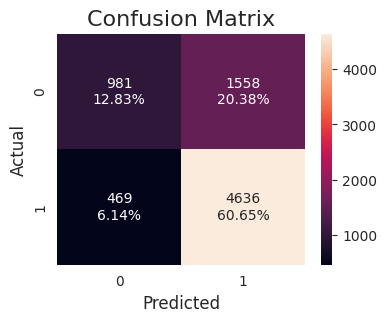

In [20]:
# 10b) Performance Metrics & Visualization

# Predictions
y_pred = final_cb.predict(X_test)
y_prob = final_cb.predict_proba(X_test)[:, 1]

# Metrics
test_f1    = f1_score(y_test, y_pred)
test_roc   = roc_auc_score(y_test, y_prob)
test_acc   = accuracy_score(y_test, y_pred)
test_prec  = precision_score(y_test, y_pred)
test_rec   = recall_score(y_test, y_pred)

print("Test Set Performance (CatBoost):")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Precision: {test_prec:.4f}")
print(f"  Recall   : {test_rec:.4f}")
print(f"  F1 Score : {test_f1:.4f}")
print(f"  ROC AUC  : {test_roc:.4f}\n")

# Confusion matrix with percentages
confusion_matrix_sklearn(final_cb, X_test, y_test)

**Observations**
* Final CatBoost model performs well on the unseen test data, with final F1 of 0.8206 and ROC AUC of 0.7710.
* The test scores are close to the scores from cross-validation, showing the model generalizes well.
* High recall indicates the model identifies almost 91% of all truly certifiable visa applications.

# 11) Model Interpretation

## 11a) Global Feature Importance

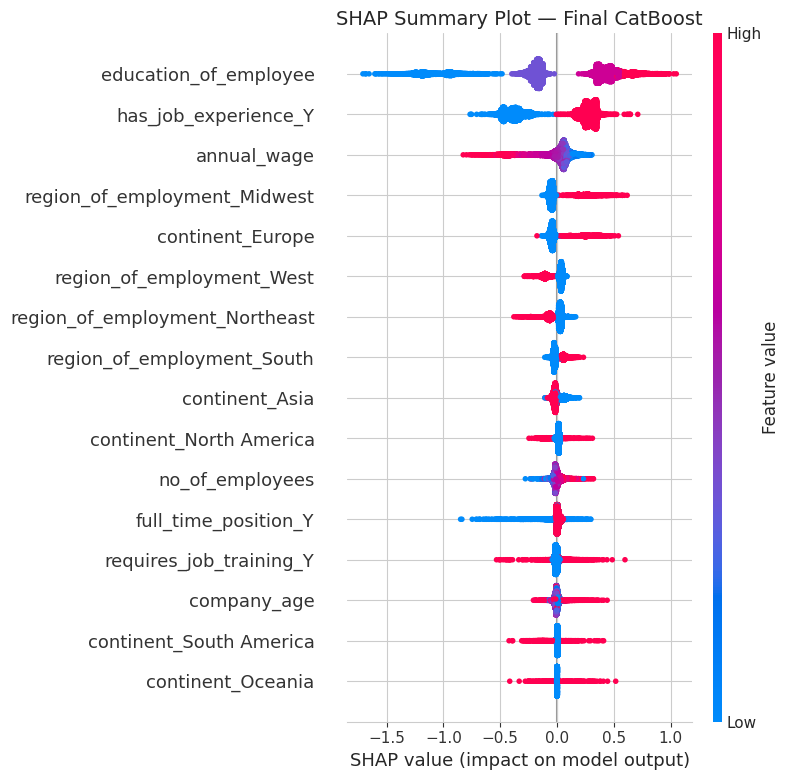

In [23]:
# 11a) Global Feature Importance

def get_feature_names(ct: ColumnTransformer):
    """
    Extract output feature names from a fitted ColumnTransformer,
    handling pipelines, OneHotEncoders, passthrough, and numeric transformers.
    """
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop' or name == 'remainder':
            continue
        # Passthrough case
        if transformer == 'passthrough':
            feature_names.extend(cols)
            continue
        # If it's a Pipeline, get the final transformer step
        if hasattr(transformer, 'named_steps'):
            transformer_step = list(transformer.named_steps.values())[-1]
        else:
            transformer_step = transformer
        # Extract names via get_feature_names_out if available
        if hasattr(transformer_step, 'get_feature_names_out'):
            try:
                names = transformer_step.get_feature_names_out(cols)
            except:
                names = cols
        elif hasattr(transformer_step, 'get_feature_names'):
            try:
                names = transformer_step.get_feature_names(cols)
            except:
                names = cols
        else:
            names = cols
        feature_names.extend(names)
    return np.array(feature_names)

# Retrieve the fitted preprocessor and model from the final pipeline
ct    = final_cb.named_steps['preprocessor']
model = final_cb.named_steps['model']

# Build the full feature-name array
feature_names = get_feature_names(ct)

# Transform the training data
X_transformed = ct.transform(X_train)

# Compute SHAP values
explainer   = shap.TreeExplainer(model, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_transformed)

# Plot the SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_transformed,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary Plot — Final CatBoost", fontsize=14)
plt.tight_layout()
plt.show()

**Observations**
* Annual wage and full-time status are the strongest predictors of certification.
* Education level and prior work experience come next in influence.
* Personal attributes trump company features (age or size) in driving the model’s decisions.

## 11b) Local Explanations

<Figure size 800x300 with 0 Axes>

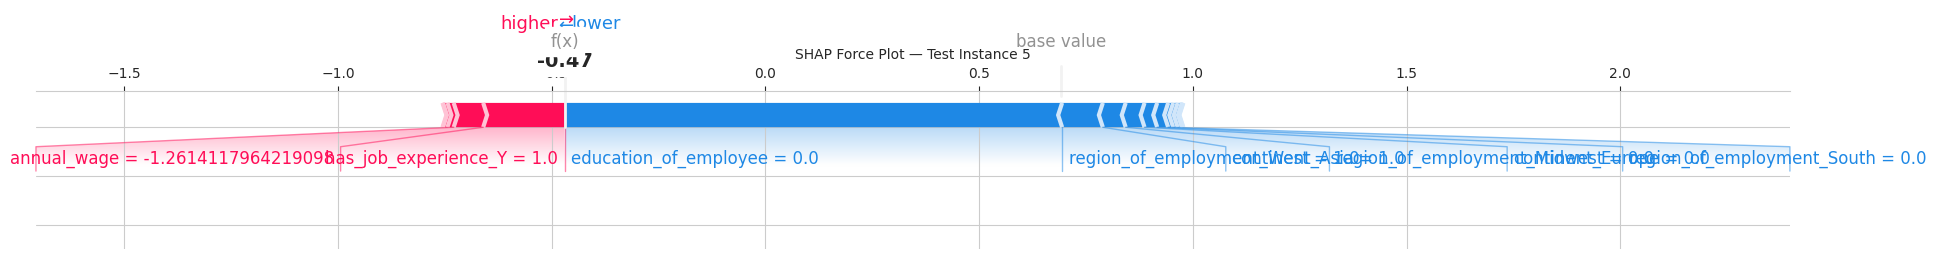

<Figure size 800x300 with 0 Axes>

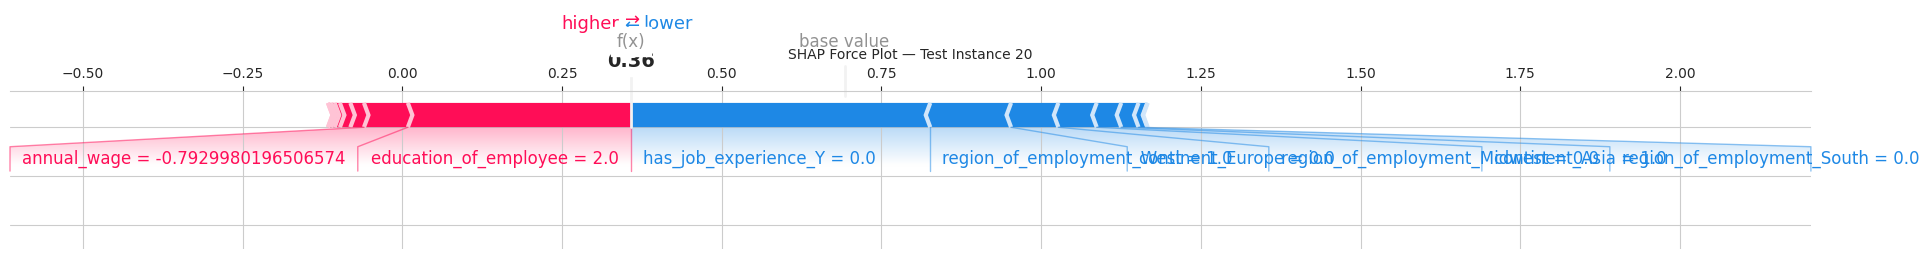

<Figure size 800x300 with 0 Axes>

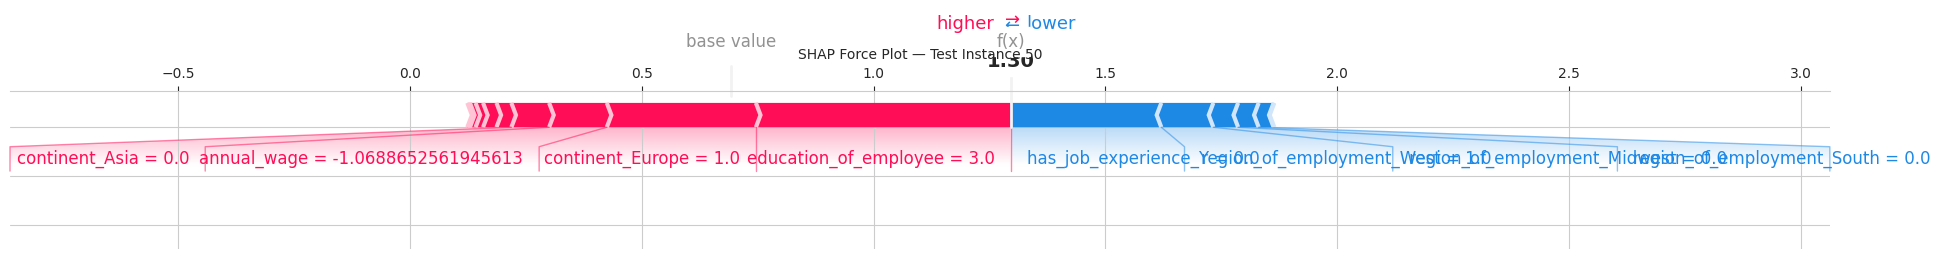

In [29]:
# 11b) Local Explanations

# Transform the test set
X_transformed_test = ct.transform(X_test)

# Compute SHAP values for the test set
shap_values_test = explainer.shap_values(X_transformed_test)

# Select a few test instances to explain
example_indices = [5, 20, 50]

# Loop and plot
for idx in example_indices:
    plt.figure(figsize=(8, 3))
    shap.force_plot(
        explainer.expected_value,
        shap_values_test[idx],
        X_transformed_test[idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"SHAP Force Plot — Test Instance {idx}", fontsize=10)
    plt.tight_layout()
    plt.show()

**Observations**
* This provides interesting examples of how key features work in individual cases.
* A doctorate plus job experience can secure approval even if salary or location aren’t ideal.
* Without prior experience (and only a bachelor’s), the model denies—even for high wages and favored origins.
* Positives (Master’s, experience, wage) and negatives (continent) pull against each other. Net balance drives the final decision.

# 11) Conclusion & Recommendations

## 12a) Project Summary

**To tackle the OFLC’s growing visa backlog, we developed an ML pipeline that predicts certification outcomes. After data cleaning, feature engineering, and benchmarking 16 models—from simple baselines to advanced ensembles—we selected a tuned CatBoost classifier as our champion. On a held-out test set it delivered an F1 of 0.82 and a ROC AUC of 0.77, mirroring its cross-validation scores and confirming its robustness. OFLC can now use this tool to flag high-probability approvals and streamline application triage.**

## 12b) Key Drivers of Visa Certification

* **Applicant Qualifications are Paramount** - The model's decisions are overwhelmingly driven by the applicant's personal qualifications. A higher level of education is the most critical predictor—with approval odds increasing directly from High School to Doctorate—followed closely by having prior job experience.

* **Key Economic and Geographic Factors** - After qualifications, several other factors have a significant impact. Higher annual wages and applying for a full-time position are both strong positive indicators. Additionally, the applicant's continent of origin is a key driver, with those from Europe receiving a notable advantage.

* **Employer Profile is Less Influential** - An important finding is that employer-specific attributes, such as the company's age and size, have a much smaller impact on the outcome than the applicant's individual profile.

## 12c) Business Recommendations

* **Implement a “Triage by Confidence” workflow** - Use the model’s scores to route applications—fast-track those >90% for minimal checks, flag <10% for thorough denial review, and assign 10–90% cases to expert adjudicators.

* **Develop data-driven reviewer guidelines** - Distill key drivers (education, experience, wage thresholds) into standardized training and checklists so every officer applies the same evidence-based criteria.

* **Establish continuous improvement** - Expand data capture—e.g. detailed job duties, technical skills, employer visa history—to feed richer inputs into future models and boost predictive accuracy over time.

## 12d) Limitations & Future Work

While this project successfully delivered a high-performing model, it is crucial to acknowledge its limitations and outline a path for continuous improvement.

**Limitations**

* **Temporal Drift** - The model was trained exclusively on data from Fiscal Year 2016. Its predictive accuracy may degrade over time as economic conditions, application trends, and immigration policies evolve.
* **Limited Feature Scope** - The dataset, while effective, lacks granular details such as specific job duties, required technical skills, or an employer's detailed visa sponsorship history. Incorporating such features could further enhance model performance.
**Potential for Inherited Bias** - The model learns from historical data. Therefore, it may inadvertently learn and perpetuate any underlying biases present in the original 2016 decision-making process.

**Future Work**

* **Incorporate Longitudinal Data** - To mitigate temporal drift, the model should be retrained and validated with data from subsequent years. This would create a more robust tool that adapts to evolving trends.
* **Perform a Bias and Fairness Audit** - A critical next step is to conduct a formal audit of the model's predictions across various demographic groups. This will ensure the model promotes equitable outcomes and allows for the mitigation of any identified biases.
* **Deploy and Monitor in a Live Environment** - The model should be deployed in a "shadow mode" to monitor its performance on live applications in real-time. This includes tracking for model drift and establishing a clear cadence for periodic retraining to maintain peak accuracy.

# Appendix A - Export to HTML

In [5]:
# Exporting to HTML
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Greg Burns - EasyVisa_Full_Code_Notebook.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Greg Burns - EasyVisa_Full_Code_Notebook.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 2377210 bytes to /content/drive/MyDrive/Colab Notebooks/Greg Burns - EasyVisa_Full_Code_Notebook.html
